In [1]:
import numpy as np
import pandas
import geopandas
import networkx as nx
import osmnx as ox
import shapely
import geopandas as gpd
from ipyleaflet import *
from ipywidgets import Layout
import geopy.distance
import contextily
import matplotlib.pyplot
import Modules.Du as D
import Modules.gargi as G


In [2]:
# Define the folder containing the database
data_folder = r".\Modules\Assets\GPR"
image_folder_gargi = r".\Modules\Assets\Drones\Bridge"
du_result = D.call_du(data_folder) #calling the result
gargi_result = G.call_gargi(image_folder_gargi)

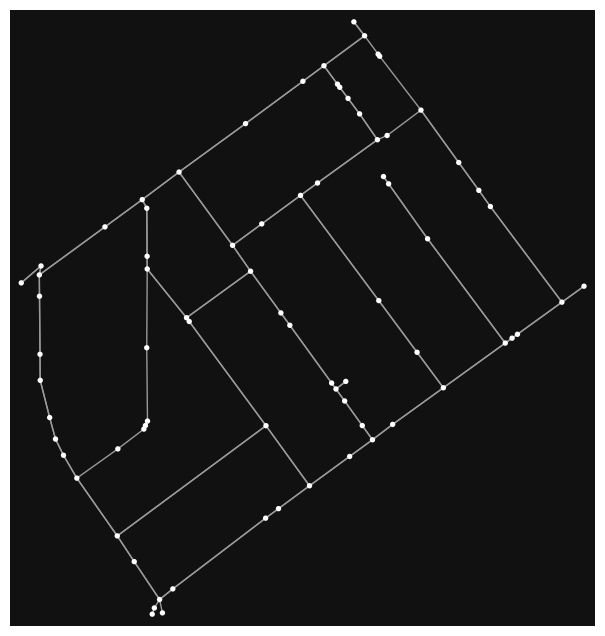

In [3]:
# Create polygon from lists of points
x = [4.347663, 4.352337, 4.349946, 4.346000, 4.346000]
y = [52.006884, 52.008783, 52.010765, 52.009467, 52.008111]

place_polygon = shapely.Polygon(zip(x,y))
# Retrieve the network graph
graph = ox.graph_from_polygon(
    # place_polygon.at[0, "geometry"],
    place_polygon,
    network_type="drive_service",
    simplify=False
)

fig, ax = ox.plot_graph(graph)
# generate all the nodes and edges
nodes, edges = ox.graph_to_gdfs(graph)

# Retrieve edges & nodes from the graph
# collect data with real distance of the road
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)
lengthdict = nx.get_edge_attributes(graph, 'length')

# generate dataframe
df = pandas.DataFrame.from_dict(lengthdict, orient='index', columns=['length'])
df.reset_index(inplace=True)
df = df.rename(columns={"index": "edges"})

In [4]:
while(1):
    user_input = input("Car or Truck (Case-sensitve)")
    if user_input == "Car" or user_input == "Truck":
        break
    print(f"Please fill in either Car or Truck and not '{user_input}'")

In [5]:
df['useful-width'] = np.random.uniform(0.5, 7.0, size=len(df)).round(2)

#get Du's data for pictures being taken in this area (Du's data already processed Ael's data)
for i in range(du_result.shape[0]):
    u, v, k = ox.nearest_edges(graph, du_result["Longitude"].iloc[i], du_result["Latitude"].iloc[i])
    way1 = (u, v, k)
    way2 = (v, u, k)
    df.loc[df["edges"] == way1, 'useful-width'] = du_result["Distance"].iloc[i]
    df.loc[df["edges"] == way2, 'useful-width'] = du_result["Distance"].iloc[i]

df['K'] = 1 / df['useful-width']

# Different road grading standerds for different vehicle types (truck or car)
# when it is car, roads with useful width >= 3m is valid
# when it is truckm roads with useful width >= 4.5m is valid
if user_input == "Car":
    df.loc[df['useful-width'] < 3.00, 'K-corrected'] = 999
    df.loc[df['useful-width'] >= 3.00, 'K-corrected'] = df['K']
else:
    df.loc[df['useful-width'] < 4.5, 'K-corrected'] = 999
    df.loc[df['useful-width'] >= 4.5, 'K-corrected'] = df['K']

#find broken bridges from Gargi and reassign k = 999 to thoese bridges
for i in range(gargi_result.shape[0]):
    u, v, k = ox.nearest_edges(graph, gargi_result["Longitude"].iloc[i], gargi_result["Latitude"].iloc[i])
    way1 = (u, v, k)
    way2 = (v, u, k)
    df.loc[df["edges"] == way1, 'K-corrected'] = 999
    df.loc[df["edges"] == way2, 'K-corrected'] = 999

df['weight'] = df['length'] * df['K-corrected']
d_K = dict(zip(df['edges'], df['K']))
d_useful_width = dict(zip(df['edges'], df['useful-width']))
d_weight = dict(zip(df['edges'], df['weight']))
# set all the colomns in dataframe into osmnx's road as attributes so can be used later by Dijkstra couculating and making visualization heatmaps
nx.set_edge_attributes(graph, d_weight, 'weight')
nx.set_edge_attributes(graph, d_K, 'K')
nx.set_edge_attributes(graph, d_useful_width, 'useful-width')

In [6]:
#Backup
graphInter = graph.copy()
edgesInter = edges.copy()
nodesInter = nodes.copy()

In [7]:
# Transform the graph to UTM
graph = ox.project_graph(graph) 
# Extract reprojected nodes and edges
nodes, edges = ox.graph_to_gdfs(graph)
convex_hull = edges.unary_union.convex_hull
stats = ox.basic_stats(graph, area=convex_hull.area)

In [8]:
origin = (
    ox.geocode_to_gdf("Frits Diepenlaan", which_result=1)  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    ox.geocode_to_gdf("prunusstraat, schipluiden", which_result=1)
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)
origin_node_id = ox.nearest_nodes(graph, origin.x, origin.y)
destination_node_id = ox.nearest_nodes(graph, destination.x, destination.y)
# Find the shortest path between origin and destination
route = nx.shortest_path(graph, origin_node_id, destination_node_id, 'weight', method='dijkstra')

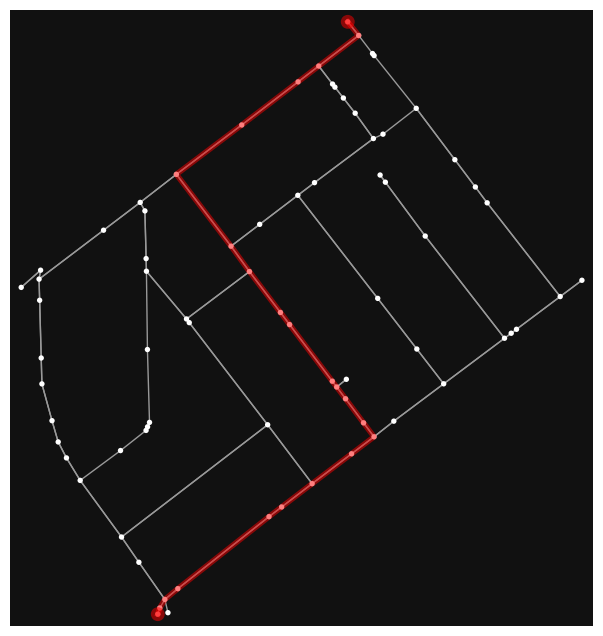

In [9]:
# Plot the shortest path
fig, ax = ox.plot_graph_route(graph, route)

In [10]:
# Get the nodes along the shortest path
route_nodes = nodes.loc[route]
# Create a geometry for the shortest path
route_line = shapely.LineString(
    list(route_nodes.geometry.values)
)
route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

buildings = ox.features_from_polygon(
    place_polygon,
    {
        "building" : True
    }
).to_crs(edges.crs)

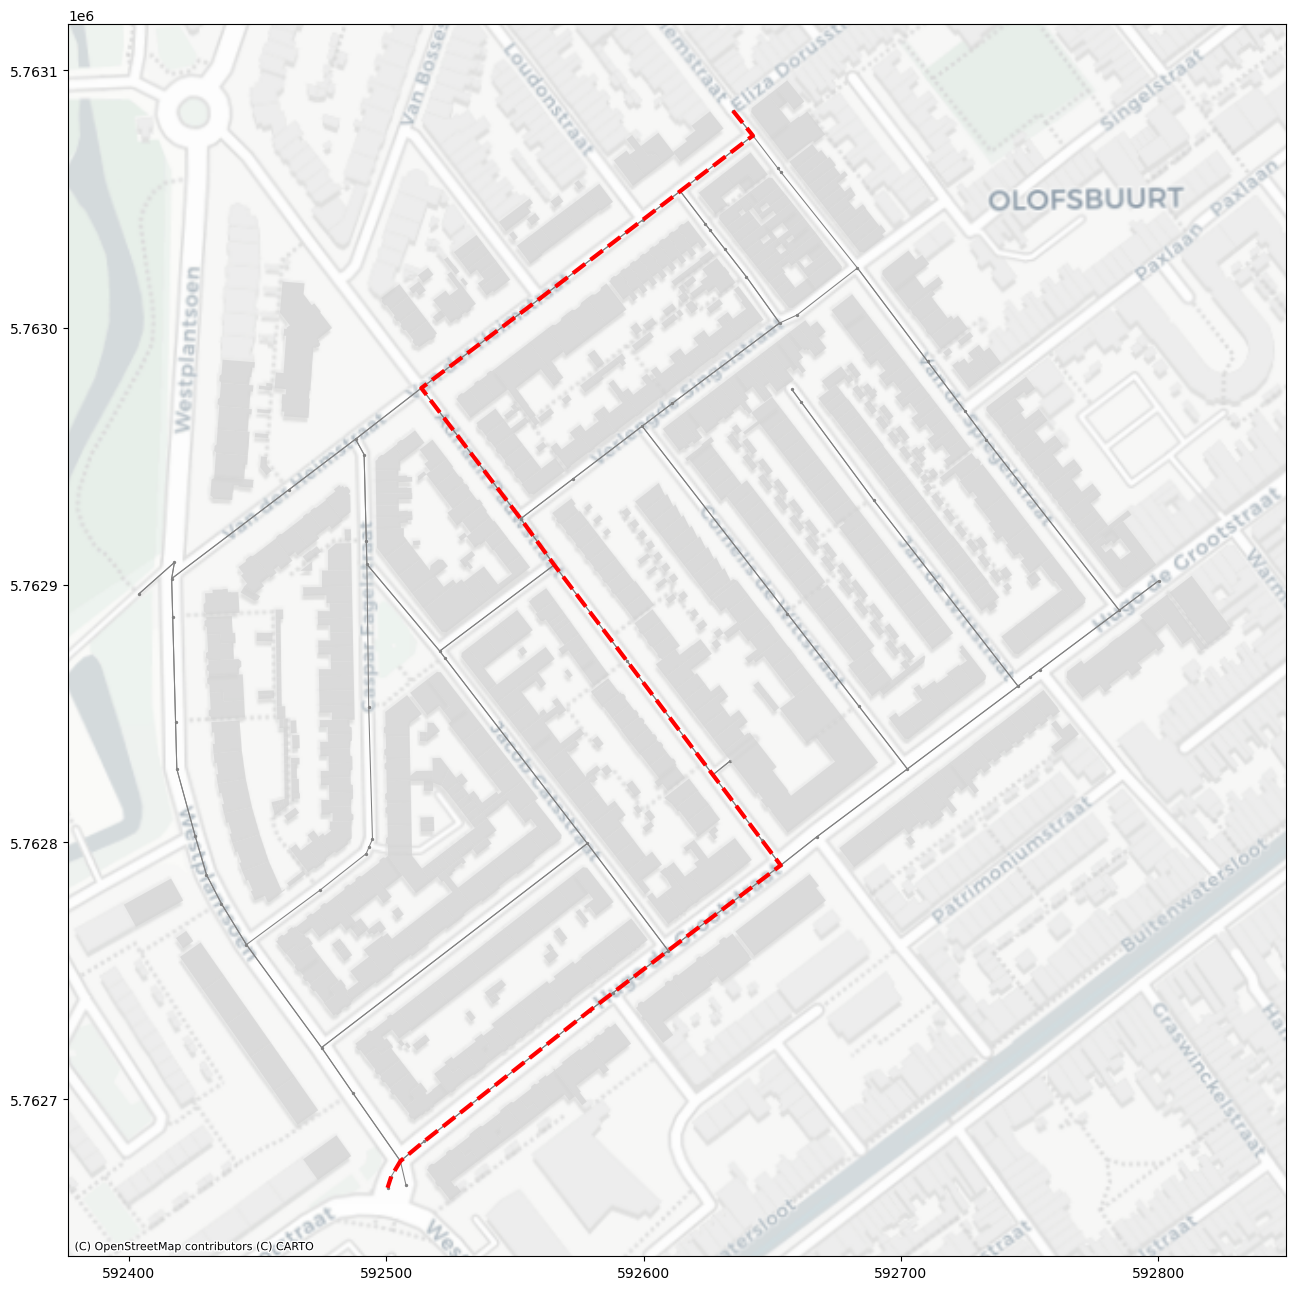

In [11]:
fig, ax = matplotlib.pyplot.subplots(figsize=(24,16))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')
# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)
# Add the route
ax = route_geom.plot(ax=ax, linewidth=3, linestyle='--', color='red')
# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)
# This is the shortest path map

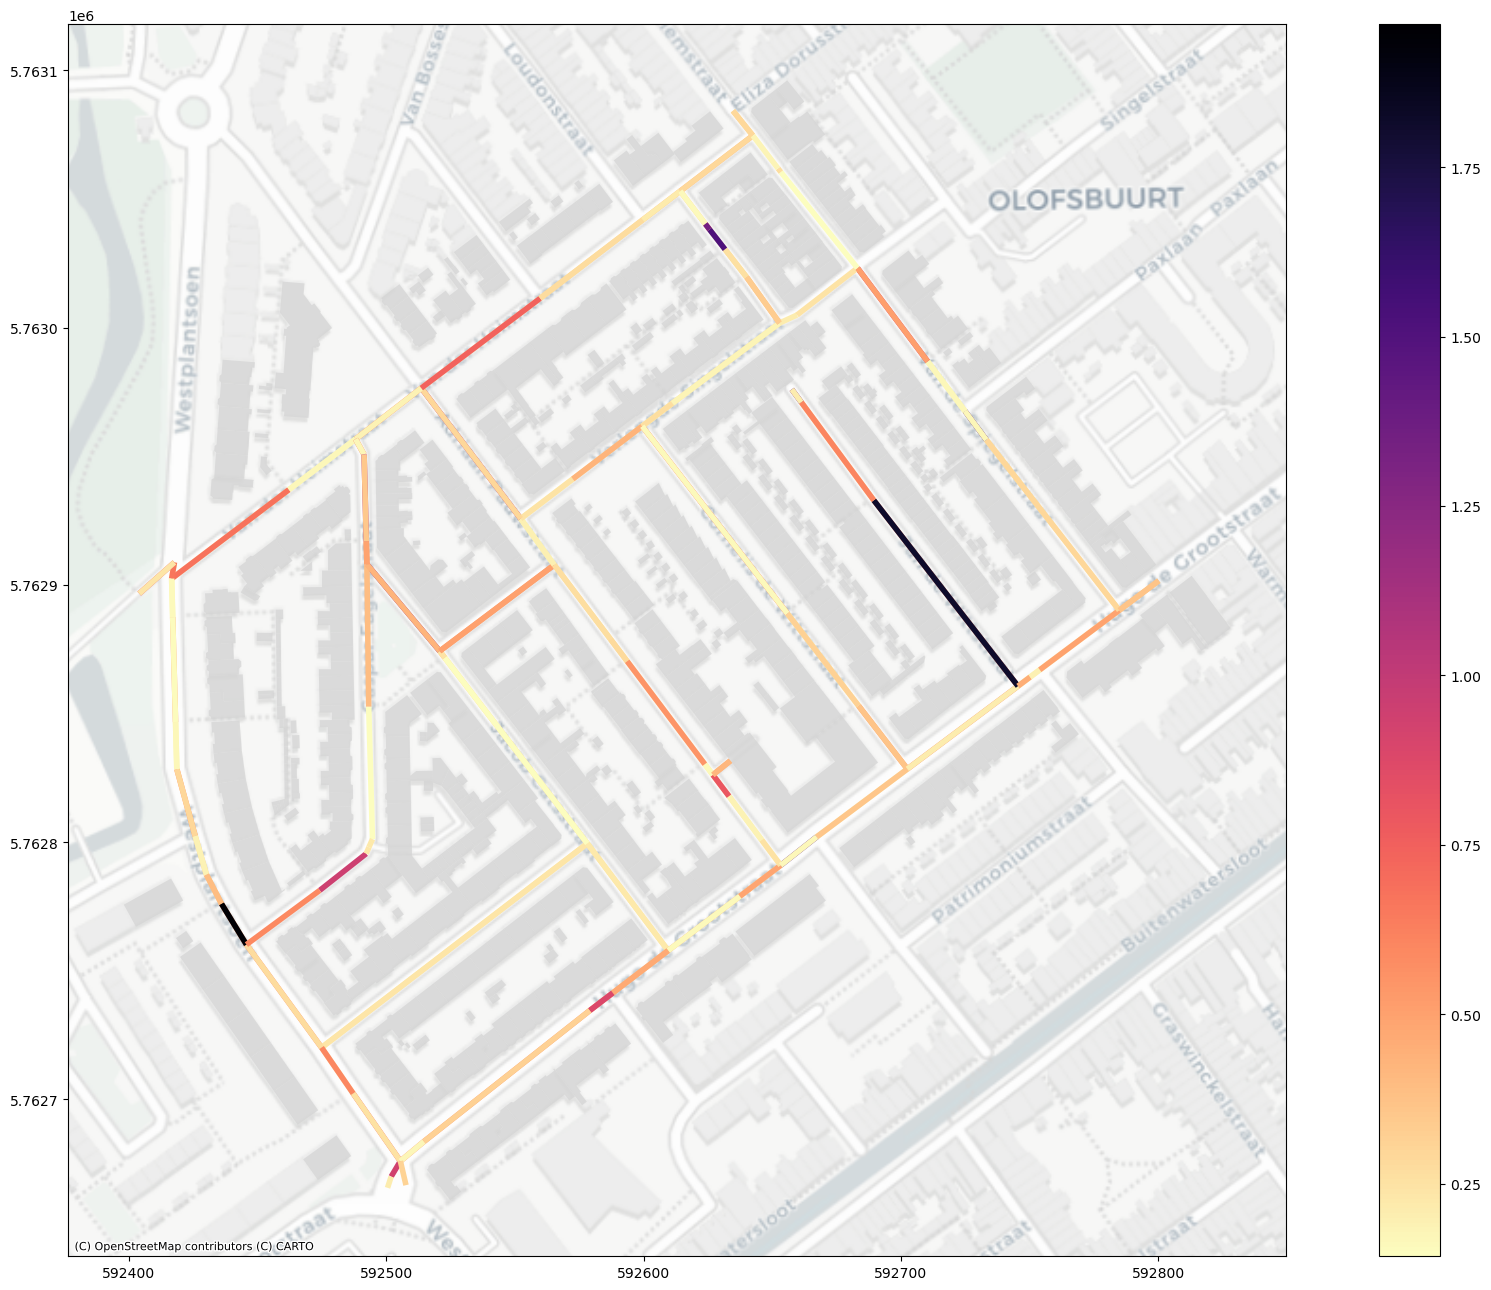

In [12]:
# visuallization of k value
ax = edges.plot(column="K", figsize=(24,16), legend=True, cmap='magma_r', linewidth=4)
# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)
# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

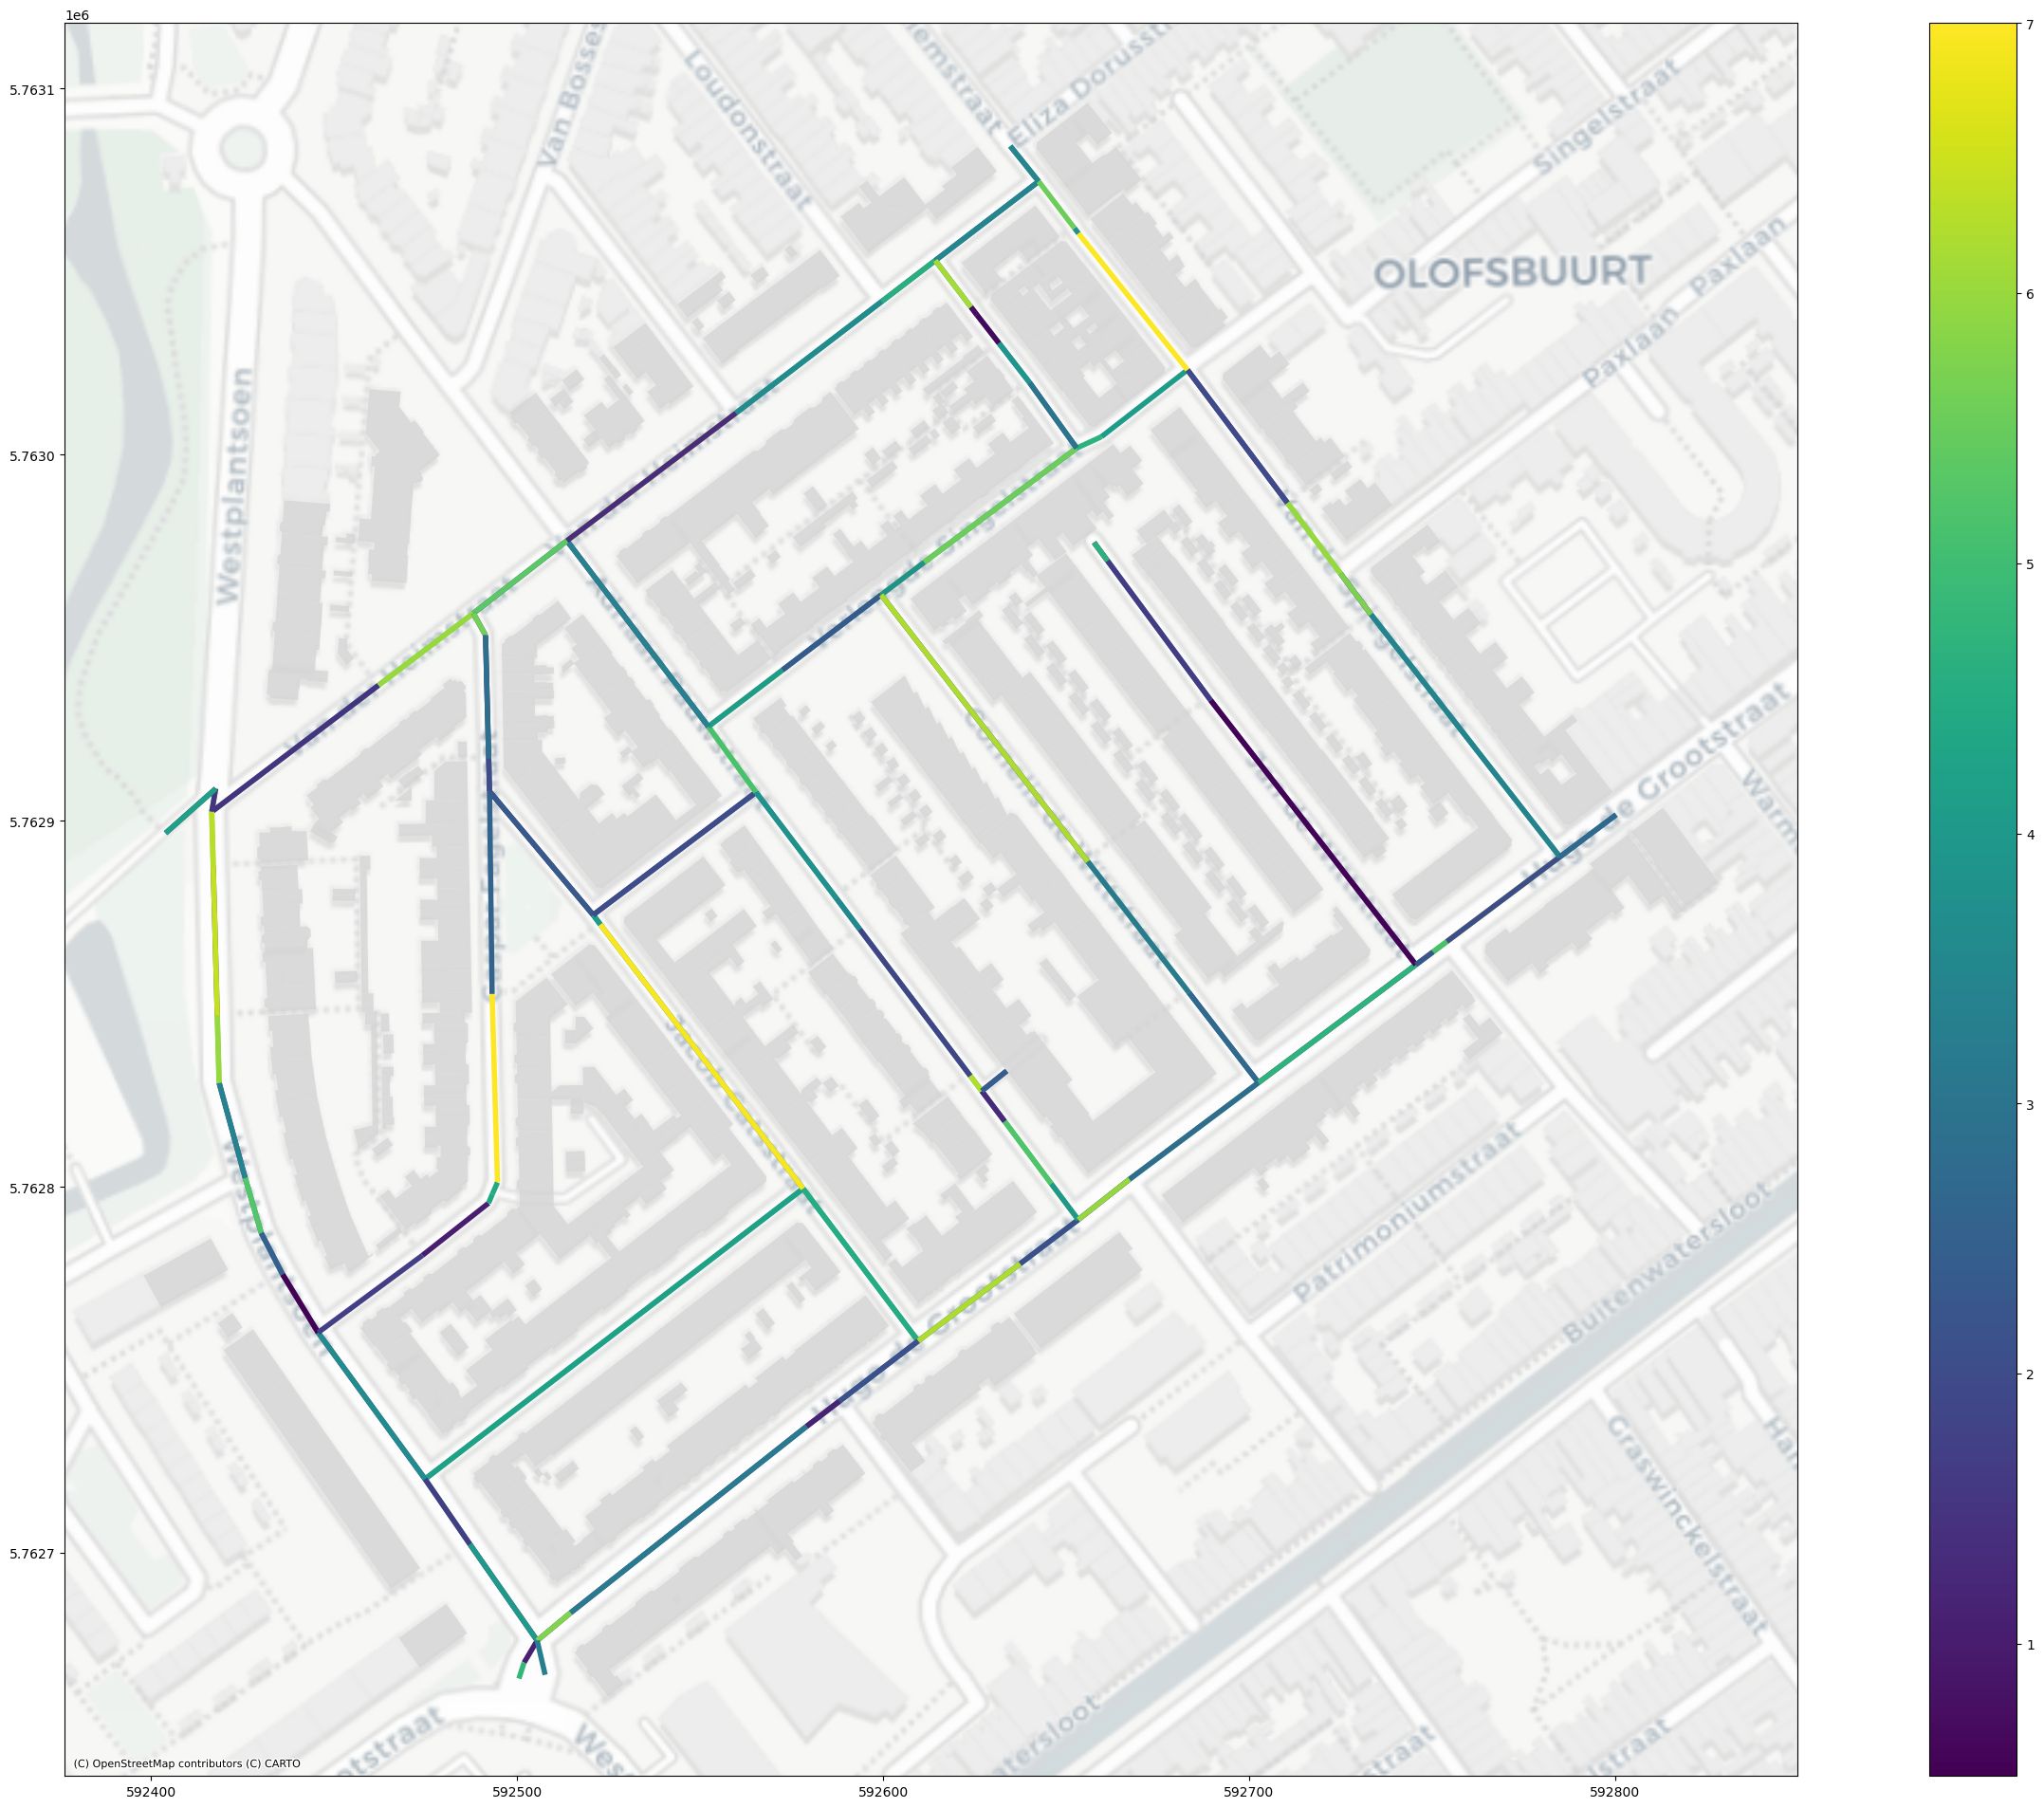

In [13]:
# visuallization of weight value 
ax = edges.plot(column="useful-width", figsize=(36,24), legend=True, cmap='viridis', linewidth=4)
# # Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)
# # Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)


In [14]:
# generate map by giving the center coordinate of the specific area in Delft and zoom to proper size to display
center = (52.008879, 4.349493)
m = Map(center=center, basemap=basemaps.CartoDB.Positron, zoom=17, layout=Layout(width='100%', height='600px'))
# style for the destination marker
to_marker_style = AwesomeIcon(
    name='circle',
    icon_color='white',
    marker_color='red',
    spin=False
)
from_marker = Marker(location=center)      # start point = BLUE marker
to_marker = Marker(location=center, icon=to_marker_style)    # end point = RED marker


c:\Users\Yangyu Liu\.conda\envs\TimeIsLife\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


c:\Users\Yangyu Liu\.conda\envs\TimeIsLife\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\Users\Yangyu Liu\.conda\envs\TimeIsLife\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\Users\Yangyu Liu\.conda\envs\TimeIsLife\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
c:\Users\Yangyu Liu\.conda\envs\TimeIsLife\Lib\site-packages\ipywidgets\widgets\widget.py:528: De

In [15]:
# In reality the assembly points and shelter spaces dataframe should be generated based on the placese found in QGIS in step one
# But for this demo to demostrate how it works, we created some random point in the neighborhood as shelter spaces and assembly points
data = {
  "latitude-y": [52.008236, 52.009476, 52.008471, 52.009309, 52.010014, 52.009187, 52.008176, 52.010223, 52.008886, 52.00891, 52.008435, 52.008528, 52.009221, 52.009552, 52.007444, 52.010052],
  "longtitude-x": [4.347604, 4.348983, 4.349382, 4.350463, 4.349797, 4.348506, 4.348769, 4.349579, 4.347581, 4.347854, 4.349408, 4.34653, 4.346558, 4.347525, 4.347285, 4.348678]
}
# the data above should be created based on QGIS filter in step1
# load data into a DataFrame object:
df_assembly = pandas.DataFrame(data)
lst_assembly = [tuple(r) for r in df_assembly.to_numpy()]

data = {
  "latitude-y": [52.009229, 52.007505, 52.010029, 52.009242],
  "longtitude-x": [4.346595, 4.347407, 4.350257, 4.351449]
}
#the data above should be created based on QGIS filter in step1
#load data into a DataFrame object:
df_shelter = pandas.DataFrame(data)
lst_shelter = [tuple(r) for r in df_shelter.to_numpy()]

 # start point = BLUE marker
 # end point = RED marker
 # To move the marker to the nearest valid assmbly/shelter point
def find(marker, lst):
    temp_shortest = 999999
    temp_ind = 0
    for i in lst:
        coord_1 = (marker.location[0], marker.location[1]) #(y,x)
        coord_2 = (float(i[0]), float(i[1])) #(y,x)
        temp_dis = geopy.distance.geodesic(coord_1, coord_2) #count the distance accoring to lat and long
        if temp_dis < temp_shortest:
            temp_shortest = temp_dis
            temp_ind = lst.index(i)
    nearest_shelter = ox.nearest_nodes(graphInter, float(lst[temp_ind][1]), float(lst[temp_ind][0])) 
    return nearest_shelter

In [16]:
path_layer_list = []
def handle_change_location(event, marker, lst1, lst2, direction):
    event_owner = event['owner']
    event_location = find(event_owner, lst1)
    marker_location = find(marker, lst2)
    shortest_path = nx.dijkstra_path(graphInter, event_location, marker_location, 
                                     weight='weight')
    while(len(path_layer_list) != 0):
        m.remove(path_layer_list[-1])
        path_layer_list.pop()
    
    shortest_path_points = nodesInter.loc[shortest_path]
    if shortest_path_points.shape[0] > 1:
        path = gpd.GeoDataFrame([shapely.LineString(shortest_path_points.geometry.values)], columns=['geometry'])
        path_layer = GeoData(geo_dataframe=path, style={'color':'red', 'weight':2})
        m.add(path_layer)
        path_layer_list.append(path_layer)
        first = (path['geometry'].iloc[0].coords[0][1], path['geometry'].iloc[0].coords[0][0])
        last = (path['geometry'].iloc[0].coords[-1][1], path['geometry'].iloc[0].coords[-1][0])
        if(direction == "from"):
            from_circle = Circle(location=first, radius=2)
            m.add(from_circle)
            path_layer_list.append(from_circle)
            to_circle = Circle(location=last, radius=2, color="red")
            m.add(to_circle)
            path_layer_list.append(to_circle)
        else:
            to_circle = Circle(location=first, radius=2, color="red")
            m.add(to_circle)
            path_layer_list.append(to_circle)
            from_circle = Circle(location=last, radius=2)
            m.add(from_circle)
            path_layer_list.append(from_circle)

    else:
        locationCoord = (shortest_path_points['geometry'].iloc[0].y, shortest_path_points['geometry'].iloc[0].x)
        to_circle = Circle(location=locationCoord, radius=2, color="purple")
        m.add(to_circle)
        path_layer_list.append(to_circle)

In [17]:
# add laypers and show map
from_marker.observe(lambda event: handle_change_location(event, to_marker, lst_assembly, lst_shelter, "from"), 'location')
to_marker.observe(lambda event: handle_change_location(event, from_marker, lst_shelter, lst_assembly, "to"), 'location')
m.add(from_marker)
m.add(to_marker)
display(m)

Map(center=[52.008879, 4.349493], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …